# Clasificación multiclase y Redes Neuronales

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

In [47]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit 

import sys
# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [48]:
# Ingresar imágenes de dígitos de 28x28
input_layer_size  = 784

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 25

#  datos de entrenamiento almacenados en los arreglos X, y
#data = loadmat(os.path.join('Datasets', 'ex3data1.mat'))
#X, y = data['X'], data['y'].ravel()

mat = loadmat(os.path.join('Datasets','emnist-letters.mat'))

data = mat['dataset']


#X_train = data['train'][0,0]['images'][0,0]
#y_train = data['train'][0,0]['labels'][0,0]
#X_test = data['test'][0,0]['images'][0,0]
#y_train = data['test'][0,0]['labels'][0,0]

#val_start = X_train.shape[0] - X_test.shape[0]
#X_val = X_train[val_start:X_train.shape[0],:]
#y_val = y_train[val_start:X_train.shape[0]]
#X_train = X_train[0:val_start,:]
#y_train = y_train[0:val_start]

X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]

#y = y.ravel()
val_start = X_train.shape[0] - X_test.shape[0]
X = X_train[val_start:X_train.shape[0],:]
y = y_train[val_start:X_train.shape[0]]
X = X_train[0:val_start,:]
y = y_test[0:val_start]

# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0
y[y == 10] = 0

m = y.size
print(m)

20800


In [49]:
print(X,'\n',y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
 [[ 1]
 [ 1]
 [ 1]
 ...
 [26]
 [26]
 [26]]


In [50]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

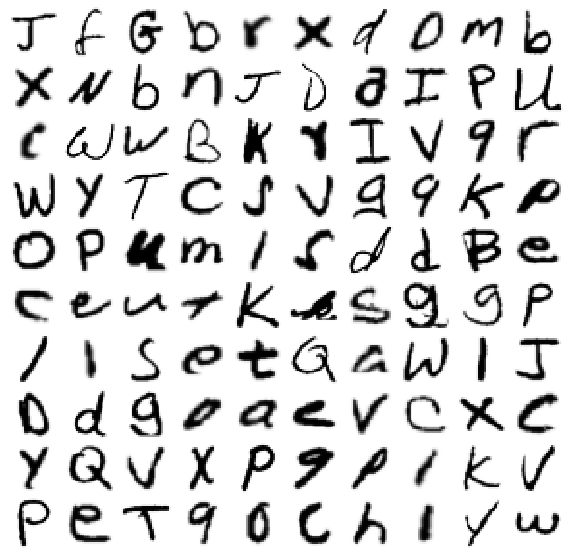

In [51]:
#Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [52]:
miArray = X # Creamos un array de 0 a 9 separados de uno en uno
yArray = y
ydim = yArray.ndim
numdim = miArray.ndim

Xnd = miArray.data
Ynd = yArray.data

byteX = miArray.itemsize
byteY = yArray.itemsize

print(type(miArray))
print(numdim," Numero/s de Dimenciones")
print(byteX," Numero/s totales de elementos en el array")
print(Xnd," Numero/s de Buffer de Elementos en el array")



print(type(yArray))
print(ydim," Numero/s de Dimenciones")
print(byteY," Numero/s totales de elementos en el array")
print(Ynd," Numero/s de Buffer de Elementos en el array")


<class 'numpy.ndarray'>
2  Numero/s de Dimenciones
1  Numero/s totales de elementos en el array
<memory at 0x0000022431E7BC88>  Numero/s de Buffer de Elementos en el array
<class 'numpy.ndarray'>
2  Numero/s de Dimenciones
1  Numero/s totales de elementos en el array
<memory at 0x00000224303E19E8>  Numero/s de Buffer de Elementos en el array


In [53]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, -2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 1

In [54]:
def sigmoid(z):
    # SIGMOIDE Calcula la funcion sigmoidea
    # J = SIGMOIDE(z) calcula la sigmoide de z.

    g = 1.0/(1.0 + np.exp(-z))
    g = expit(z)

    return g

In [55]:
def lrCostFunction(theta, X, y, lambda_reg):
    
    # Inicializa algunos valores utiles
    m = y.size
    
    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)
    
    J = 0
    grad = np.zeros(theta.shape)
    
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_reg / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_reg / m) * temp

    return J, grad

In [56]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo         : {:.6f}'.format(J))
print('Costo esperadot: 2.534819')
print('-----------------------')
print('Gradientes:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradientes esperados:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Costo         : 3.077085
Costo esperadot: 2.534819
-----------------------
Gradientes:
 [-0.583071, -0.375576, -0.267112, -1.158647]
Gradientes esperados:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases $K$ en nuestro conjunto de datos. En el conjunto de datos de dígitos escritos a mano, $K = 10$, pero su código debería funcionar para cualquier valor de $K$.

El argumento `y` de esta función es un vector de etiquetas de 0 a 9. Al entrenar el clasificador para la clase $k \in \{0, ..., K-1 \} $, querrá un vector K-dimensional de etiquetas $y$, donde $y_j \ in 0, 1$ indica si la instancia de entrenamiento $j ^ {th}$ pertenece a la clase $k$ $(y_j = 1)$, o si pertenece a una clase diferente $(y_j = 0)$.

Además, se utiliza `optimize.minimize` de scipy para este ejercicio.
<a id="oneVsAll"></a>

In [57]:
def oneVsAll(X, y, num_labels, lambda_reg):

    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))
    #all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    #X = np.column_stack([np.ones((m, 1)), X])
    #X = np.column_stack((np.ones((m,1)), X))

    #X = np.column_stack((np.ones((m,1)), X))
    
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        #options = {'minimize': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_reg), 
                                jac = True, 
                                method = 'dogleg',
                                options = {'minimize'}) 
        
        all_theta[c] = res.x
    
    return all_theta

In [58]:
lambda_reg = 0.01
all_theta = oneVsAll(X, y, num_labels, lambda_reg)

TypeError: _minimize_newtoncg() argument after ** must be a mapping, not set

In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas. 
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase. 
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1] 
    predice clases 0, 2, 0, 1 para 4 ejemplos).
    
    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """
    
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m, 1)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

In [ ]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[2002:2003, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((1, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

displayData(X[2002:2003, :])

<label><p>Bibliografia:</p> 
    <ul>
        <li>
            https://www.thetopsites.net/article/52573858.shtml
        </li>
        <li>
            https://lionbridge.ai/datasets/15-best-ocr-handwriting-datasets/
        </li>
        <li>
            https://www.nist.gov/itl/products-and-services/emnist-dataset
        </li>
    </ul>
    
</Label>